In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from keras_preprocessing import image
import random

In [2]:
p = Path('images/')
dirs = p.glob('*')

image_data = []

for folder_name in dirs:
    
    for image_path in folder_name.glob('*.jpg'):
        
        img = image.load_img(image_path,target_size=(64,64))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        
img_data = np.array(image_data, dtype='float32')/255.0   ##Normalizing the data

idx = list(range(0,808))
random.shuffle(idx)
img_data = img_data[idx]

In [3]:
print(img_data.shape)

(808, 64, 64, 3)


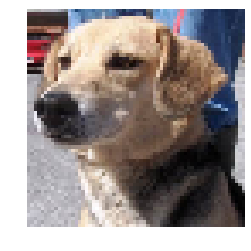

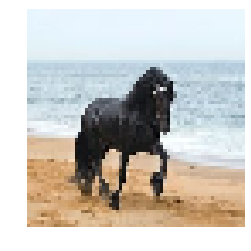

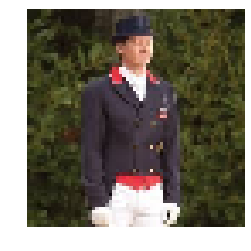

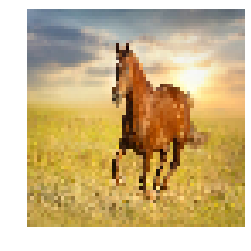

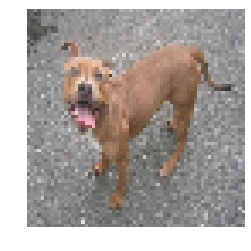

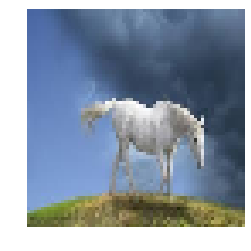

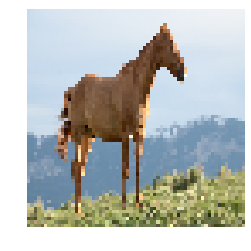

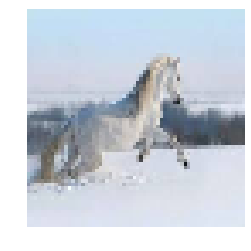

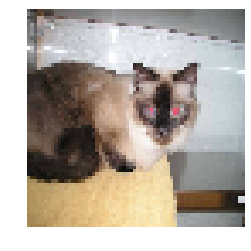

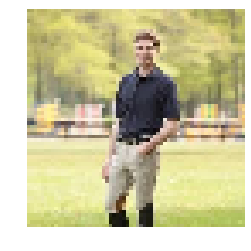

In [4]:
def drawImg(image):
    
    from matplotlib import pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return

for ix in range(10):
    drawImg(img_data[ix])

In [5]:
#Noise Functions
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + noise)
     
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [6]:
#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = int(images.shape[0]/2);
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:],0,1,0.5)
    
    noisy_set = []
    for data in [noise1,noise2]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)

In [7]:
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    random.shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

In [8]:
#Getting the noisy image set
noisy_set = add_noise(img_data)
ground_truth,noisy_images = pair_shuffle(img_data,noisy_set)

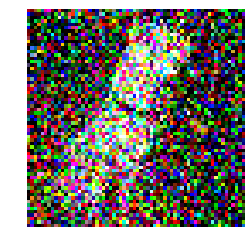

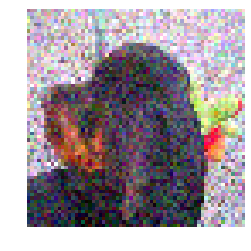

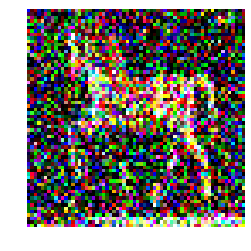

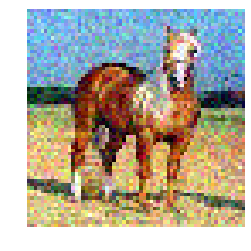

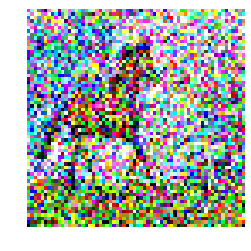

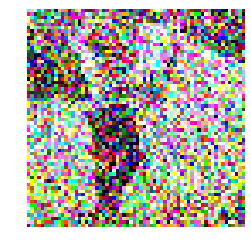

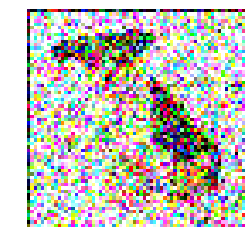

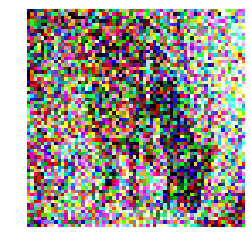

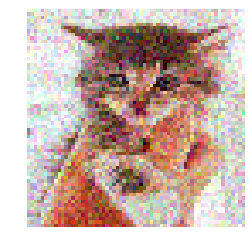

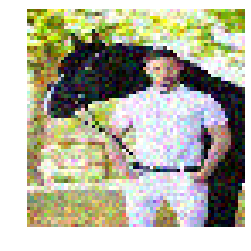

(808, 64, 64, 3)


In [9]:
for ix in range(10):
    drawImg(noisy_images[ix])
print (noisy_images.shape)

In [10]:
#Split into training and cross validation
train_size = int(ground_truth.shape[0]*0.8)
x_train = ground_truth[0:train_size]
x_train_noisy = noisy_images[0:train_size]
x_test = ground_truth[train_size:]
x_test_noisy = noisy_images[train_size:]

print(x_train_noisy.shape)
print(x_test_noisy.shape)

(646, 64, 64, 3)
(162, 64, 64, 3)


In [12]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model,Sequential
from keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

In [64]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    gateFactor = Input(tensor = K.variable([gatePercentageFactor]))
    fractionG = Lambda(lambda x: x[0]*x[1])([inputLayer,gateFactor])
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return gateFactor,fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

def get_cnn_architecture(weights_path=None):
    
    input_img = Input(shape=(64,64,3))  # adapt this if using `channels_first` image data format
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    gf1,fg1,c1 = get_gated_connections(0.1,x1)
    
    x = MaxPooling2D((2, 2), padding='same')(fg1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
    gf2,fg2,c2 = get_gated_connections(0.2,x2)

    x = MaxPooling2D((2, 2), padding='same')(fg2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
    gf3,fg3,c3 = get_gated_connections(0.3,x3)
    
    x = MaxPooling2D((2, 2), padding='same')(x3)
    x4 = Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
    gf4,fg4,c4 = get_gated_connections(0.4,x4)
    
    x = MaxPooling2D((2, 2), padding='same')(x4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x) 
    
    x = UpSampling2D((2, 2))(x5)
    y1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x) 
    jt4 = Add()([y1,c4])
    x = UpSampling2D((2, 2))(jt4)
    
    y2 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) 
    jt3 = Add()([y2,c3])
    x = UpSampling2D((2, 2))(jt3)
    
    y3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x) 
    jt2 = Add()([y3,c2])
    x = UpSampling2D((2, 2))(jt2)
    
    jt1 = Add()([x,c1])
    y4 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(jt1)
    y5 = Conv2DTranspose(3, (3, 3), activation='relu', padding='same')(y4) 
    
    layers = y5
    
    model = Model([input_img,gf1,gf2,gf3,gf4],layers)
    model.compile(optimizer='sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
    model.summary()
    return model

In [65]:
model = get_cnn_architecture()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 64, 64, 64)   1792        input_22[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           [(1,)]               0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 64, 64, 64)   0           conv2d_75[0][0]                  
                                                                 input_23[0][0]             

In [14]:
import tensorflow as tf

In [15]:
ph = tf.placeholder(shape=[None,2], dtype=tf.float32)

In [ ]:
hist = model.fit([x_train_noisy], [x_train],
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=([x_test_noisy], [x_test]),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)])

Train on 646 samples, validate on 162 samples
Epoch 1/50
646/646 [==============================] - 31s 48ms/sample - loss: 0.1325 - acc: 0.4621 - val_loss: 0.1100 - val_acc: 0.4900
Epoch 2/50
646/646 [==============================] - 29s 45ms/sample - loss: 0.1094 - acc: 0.4773 - val_loss: 0.1077 - val_acc: 0.5032
Epoch 3/50
646/646 [==============================] - 28s 44ms/sample - loss: 0.0899 - acc: 0.4841 - val_loss: 0.0326 - val_acc: 0.4449
Epoch 4/50
646/646 [==============================] - 31s 49ms/sample - loss: 0.0303 - acc: 0.4621 - val_loss: 0.0294 - val_acc: 0.5036
Epoch 5/50
646/646 [==============================] - 64s 99ms/sample - loss: 0.0278 - acc: 0.4854 - val_loss: 0.0271 - val_acc: 0.5048
Epoch 6/50
646/646 [==============================] - 57s 88ms/sample - loss: 0.0259 - acc: 0.5001 - val_loss: 0.0255 - val_acc: 0.5317
Epoch 7/50
646/646 [==============================] - 32s 50ms/sample - loss: 0.0245 - acc: 0.5129 - val_loss: 0.0241 - val_acc: 0.5612
Ep

In [ ]:
pic = model.predict(x_test_noisy[:2])

In [ ]:
drawImg(pic[1])

In [ ]:
drawImg(x_test_noisy[1])

In [ ]:
drawImg(x_test[1])

In [58]:
model = Sequential()

model.add(Input(shape=(64,64,3)))
model.add(Conv2D(64,(3,3),activation='relu',strides=(2,2),padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2D(128,(3,3),activation='relu',strides=(2,2),padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2D(256,(3,3),activation='relu',strides=(2,2),padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2DTranspose(128, kernel_size=(5,5), padding='same'))
model.add(UpSampling2D((2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2DTranspose(64, kernel_size=(5,5), padding='same'))
model.add(UpSampling2D((2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2DTranspose(32, kernel_size=(5,5), padding='same'))
model.add(UpSampling2D((2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(0.2))

model.add(Conv2DTranspose(3,kernel_size=(5,5),padding='same',strides=(1,1),activation='tanh'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
dropout_66 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
dropout_67 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 16, 16, 128)     

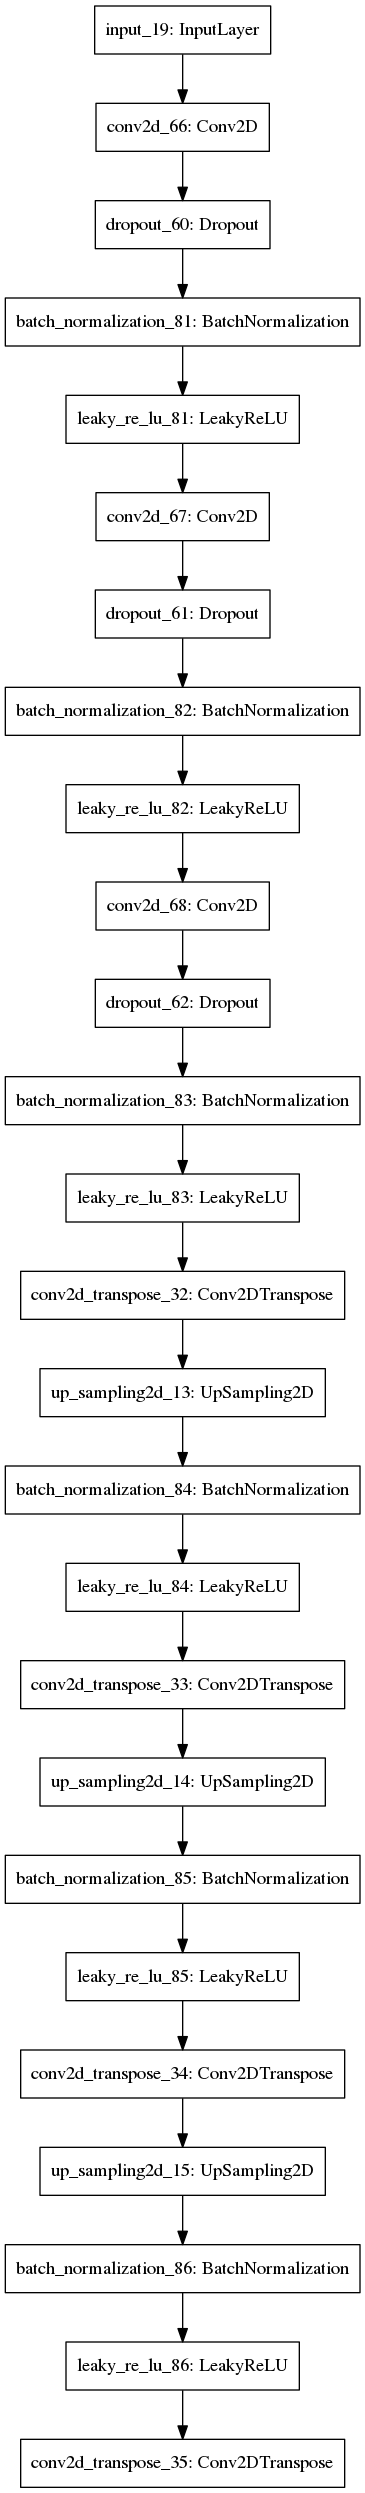

In [51]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='Denoising_autoencoder.png')